In [1]:
# !pip install numba & conda install cudatoolkit

In [3]:
################# import libs #############

from utils import *
#from numba import jit, cuda


In [2]:
# see data path
print('LOB Path: ',NqPath)

LOB Path:  C:/Users/kasra/Downloads/Ten-Surf/Tensurf-RL/tensurfrl/data/LOB_ov_Added_NQU22-CME_Vol1000_5-22-2022_07-29-2022.lob


In [3]:
preProcessedData = lobPreprocessing(NqPath)
trainData, testData, dataTrain, dataTest = preProcessedData.final()

In [4]:
def string_to_nplist(x):

    if pd.isnull(x):
        return []
    else:
        
        return np.array(ast.literal_eval(x))

In [5]:
def read_data(file_name, col_names, col_list):

    data = pd.read_csv(file_name, names=col_names, delimiter="|")
    
    for col in col_list:
        data[col] = data[col].apply(lambda x:  string_to_nplist(x))
    data["DateTime"] = pd.to_datetime(data["DateTime"])
    data.set_index(["DateTime"], inplace=True)

    return data

In [6]:
col_names =  ["DateTime","Open","High","Low","Last","Volume","NumTrades","BidVolume","AskVolume",\
            "NumberOfBidTrades","NumberOfAskTrades","AskBidDiffHigh","AskBidDiffLow","AskBidNumTradesDiffHigh","AskBidNumTradesDiffLow",\
            "UpDownVolDiffHigh", "UpDownVolDiffLow","SumBid","SumAsk","BidPrices","BidVolumes","AskPrices","AskVolumes"]

col_list = ["BidPrices","BidVolumes","AskPrices","AskVolumes"]

In [7]:
read_data(NqPath,col_names,col_list)

KeyboardInterrupt: 

In [5]:
######################### Train Section ############################
####################################################################


################ data preprocessing  for forex STOCK ###########

preProcessedData = lobPreprocessing(NqPath)
trainData, testData, dataTrain, dataTest = preProcessedData.final()


################## initialize models,memory and etc ##################
       
Actor_model = Actor(np.shape(trainData)[1], np.shape(outPutOfQ)[0])
Actor_model_main= Actor_model.model

Critic_model= Critic(np.shape(trainData)[1])
Critic_model_main= Critic_model.model

env = dict()
memory = deque(maxlen = relayMemorySize)
selectedAction = actions[random.randint(0, len(actions)-1)]

# td_target_batch = []
# advatnage_batch = []

############################### gpu supporting########################
#!@jit(target ="cuda")

########################## Train loop #########################

for i in range(len(trainData)-1):

    ############################ current state #############
    state = trainData[i, :]
    
    ########################### transition between state and action #####################
    env_ = openOrClosePosition(env, selectedAction, i, dataTrain, margin,  Sl, Tp)   
    env = env_.tradeCheck() 

    ################################## next observation #################                  
    nextState = trainData[i+1, :] 
    
    ################################# reward calculation ######
    rewardCalculating = rewardCalculation(env, i, selectedAction, dataTrain, stepSwith = True)
    reward = rewardCalculating.reward()
    
        
    def td_targets(reward, next_state):

        v_value = Critic_model_main.predict(
        np.reshape(nextState,(1, np.shape(nextState)[0])),verbose=0)
        
        return (reward + (gamma * v_value))

    def advatnages(td_target, baselines):
    
        return (td_target - baselines)


    td_target = td_targets((reward) , nextState)
    
    advantage = advatnages(td_target, Critic_model_main.predict(np.reshape(state,(1, np.shape(state)[0])),verbose=0))
   

    ################################### saving to memory ###################
    memory.append([state, actionConverting[actions.index(selectedAction)], reward, nextState,td_target,advantage])  

    ########################## action selection ########################
    
    if len(memory) % batchSize==0:
       
        # trainer = updatinQtable(memory, batchSize, Q, gamma, nextState)
        # Q = trainer.updating()
        print("A2C updated")
        
        # if epsilon > epsilonFinal:
        #    epsilon *= epsilonDecay

        Actor_model_main = Actor_model.train(memory,Actor_model_main)
        
        Critic_model_main = Critic_model.train(memory,Critic_model_main)

        memory = deque(maxlen = relayMemorySize)
        # td_target_batch = []
        # advatnage_batch = []
    
    #####################  select action according to decided policy #####################

    policy_ = policy(Actor_model_main, actions, state, epsilon)

    selectedAction = policy_.actionSelection()
    
    
    ############################# state updating ##########################
    state = nextState

    ############################## save models ##########################

#Q.save("DQN.csv")
    


A2C updated


ValueError: in user code:

    File "c:\Users\kasra\.conda\envs\Ai\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kasra\.conda\envs\Ai\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kasra\.conda\envs\Ai\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kasra\.conda\envs\Ai\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\kasra\.conda\envs\Ai\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\kasra\.conda\envs\Ai\lib\site-packages\keras\engine\input_spec.py", line 200, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "sequential" expects 1 input(s), but it received 16 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 40) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 40) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 40) dtype=float32>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 40) dtype=float32>, <tf.Tensor 'IteratorGetNext:4' shape=(None, 40) dtype=float32>, <tf.Tensor 'IteratorGetNext:5' shape=(None, 40) dtype=float32>, <tf.Tensor 'IteratorGetNext:6' shape=(None, 40) dtype=float32>, <tf.Tensor 'IteratorGetNext:7' shape=(None, 40) dtype=float32>, <tf.Tensor 'IteratorGetNext:8' shape=(None, 40) dtype=float32>, <tf.Tensor 'IteratorGetNext:9' shape=(None, 40) dtype=float32>, <tf.Tensor 'IteratorGetNext:10' shape=(None, 40) dtype=float32>, <tf.Tensor 'IteratorGetNext:11' shape=(None, 40) dtype=float32>, <tf.Tensor 'IteratorGetNext:12' shape=(None, 40) dtype=float32>, <tf.Tensor 'IteratorGetNext:13' shape=(None, 40) dtype=float32>, <tf.Tensor 'IteratorGetNext:14' shape=(None, 40) dtype=float32>, <tf.Tensor 'IteratorGetNext:15' shape=(None, 40) dtype=float32>]


c:\Users\kasra\Downloads\Ten-Surf\Tensurf-RL\tensurfrl\RL-A2C\utils\showTraderResults.py:127: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(t, listOfMargin, '-ok', color="blue", linewidth = 3)


{'numberOfTrades': 2, 'numberOfBuy': 0, 'numberOfSell': 1, 'numberOfPositveSell': 0, 'numberOfPositiveBuy': 0, 'profitInBuyTrades': 0, 'profitInSellTrades': 0, 'netProfit': -4.75, 'totallProfit': 0, 'totallLoss': -4.75, 'numberOfLossBuy': 0, 'lossInBuyTrades': 0, 'numberOfLossSell': 1, 'lossInSellTrades': -4.75, 'netBuy': 0, 'netSell': 4.75, 'winRate': 0.0, 'lossRate': 50.0}


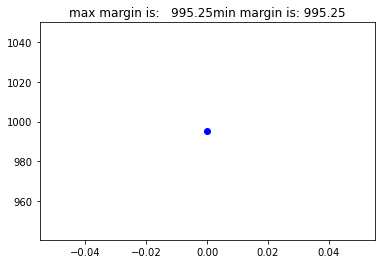

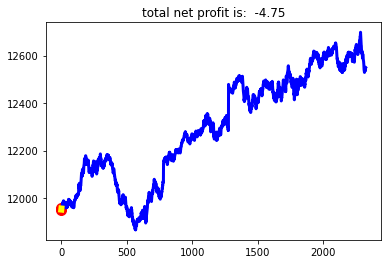

In [ ]:
################## show results #############################
showTraderResults_ = showTraderResults(envTest, dataTest["Last"].values)

statements = showTraderResults_.final()

print(statements)